### **1. Import necessary libraries and modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, LossTrackingCallback, AccuracyTrackingCallBack
from utils import print_model_structure, count_unique_values

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **2. Import MNIST data:**

In [2]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [3]:
#tf.compat.v1.enable_eager_execution()
input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = RowWiseQuantized(128)(flatten_layer)
quantized_dense_layer_2 = tf.keras.activations.relu(quantized_dense_layer)
output_layer = RowWiseQuantized(10)(quantized_dense_layer_2)
output_layer_2 = tf.keras.activations.softmax(output_layer)
quantized_model = Model(inputs=input_layer, outputs=output_layer_2)

### **4. Print model structure for timely inspection**

In [4]:
print_model_structure(quantized_model)


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x106a61b50>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x106a61c70>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x17b47b610>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x17c0411f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x174544790>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x17b58af40>
  - Input Shape: (None, 10)

### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`. Note that only `SCCEMinMaxBin` and `SCCEMaxBin` take the `row_wise` argument.

In [5]:

# Initialize your custom loss function
loss_function = SCCEMaxBin(
    layers=[
        quantized_model.get_layer(index=2),
        quantized_model.get_layer(index=4)
    ],
    penalty_rate=0.1,
    row_wise=1 # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
               # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
)

# Compile your model
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_function.compute_total_loss,
    metrics=['accuracy']
)


### **6. Initialize callbacks, train and evaluate the model**

In [6]:
# Initialize your callbacks
scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=2))
scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=4))
penalty_callback = LossTrackingCallback(loss_function=loss_function)
accuracy_callback = AccuracyTrackingCallBack(quantized_model.get_layer(index=4))

# Train your model
quantized_model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[
        scale_tracking_callback_first_dense_layer,
        scale_tracking_callback_second_dense_layer,
        penalty_callback,
        accuracy_callback
    ],
    batch_size=32
)

# Evaluate
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.9910 - accuracy: 0.8815 - val_loss: 1.1936 - val_accuracy: 0.9286
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.8785 - accuracy: 0.9341 - val_loss: 0.7046 - val_accuracy: 0.9348
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6486 - accuracy: 0.9355 - val_loss: 0.5911 - val_accuracy: 0.9325
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5741 - accuracy: 0.9326 - val_loss: 0.6504 - val_accuracy: 0.9107
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5279 - accuracy: 0.9330 - val_loss: 0.5103 - val_accuracy: 0.9339
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4992 - accuracy: 0.9340 - val_loss: 0.4673 - val_accuracy: 0.9396
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5074 - accuracy: 0.9324 - val_loss: 0.4862 - val_accuracy

### **7. Plot the scale factor values, accuracy and loss**

/Users/anuunchinbat/Desktop/Thesis/qat/custom_callbacks.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


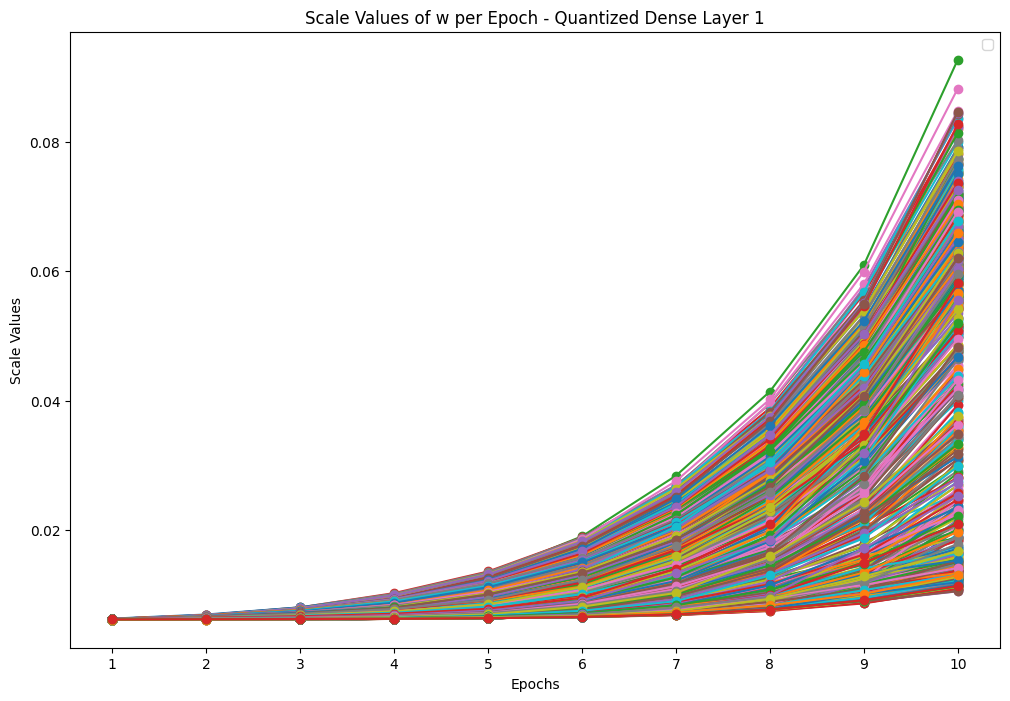

/Users/anuunchinbat/Desktop/Thesis/qat/custom_callbacks.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


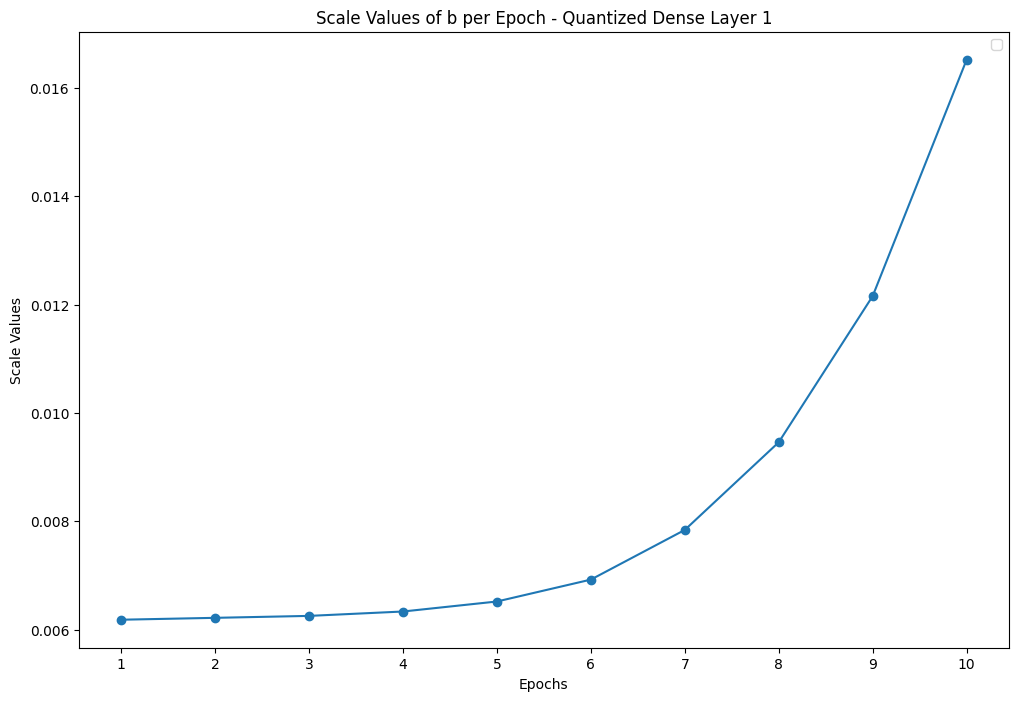

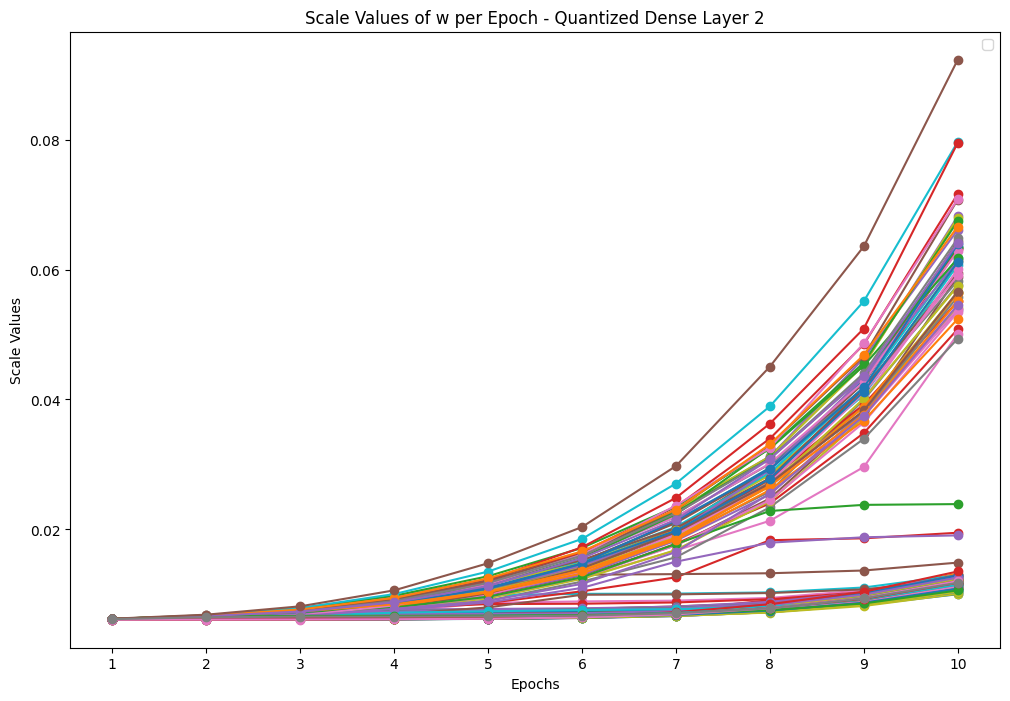

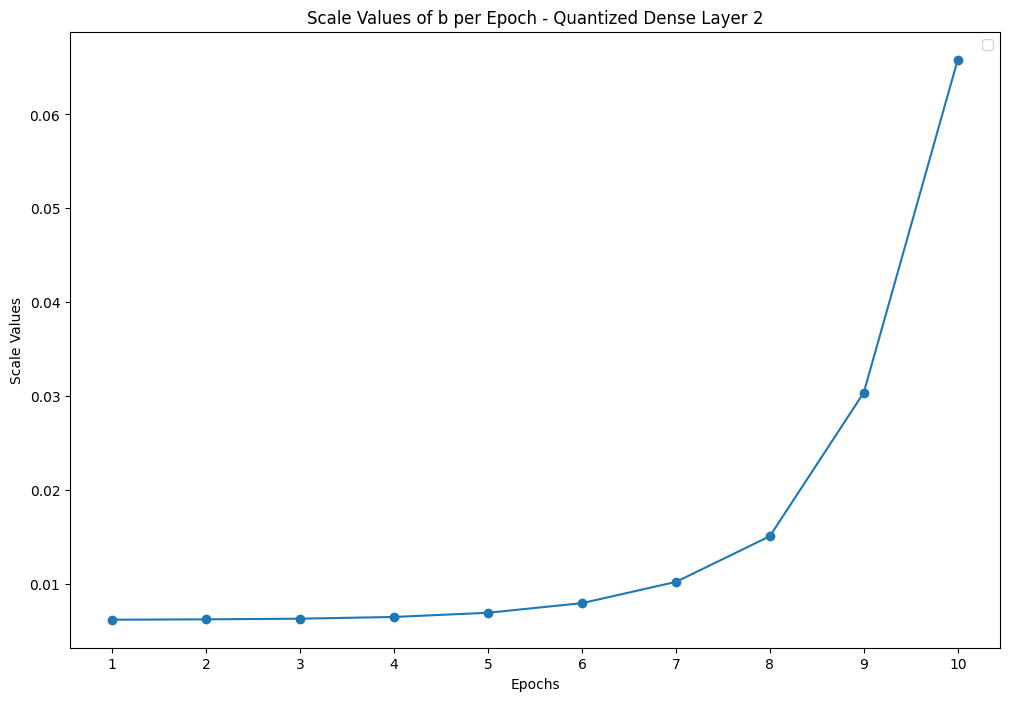

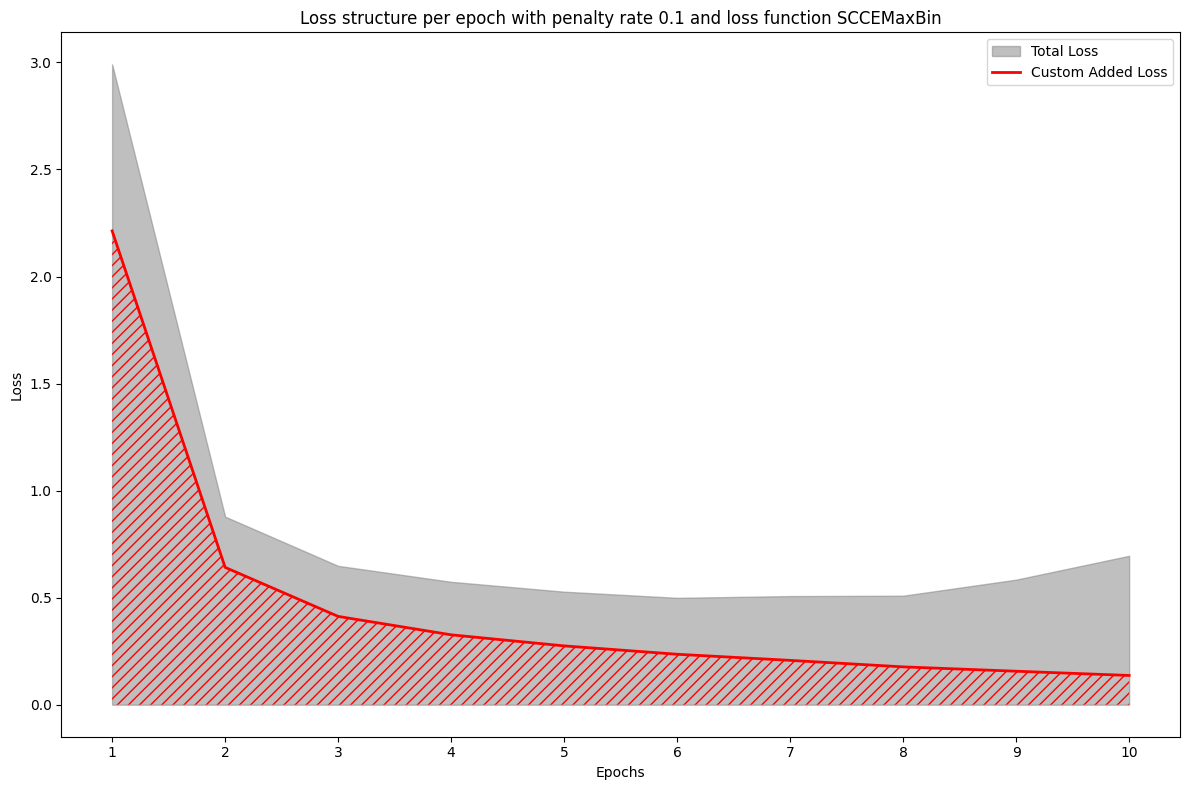

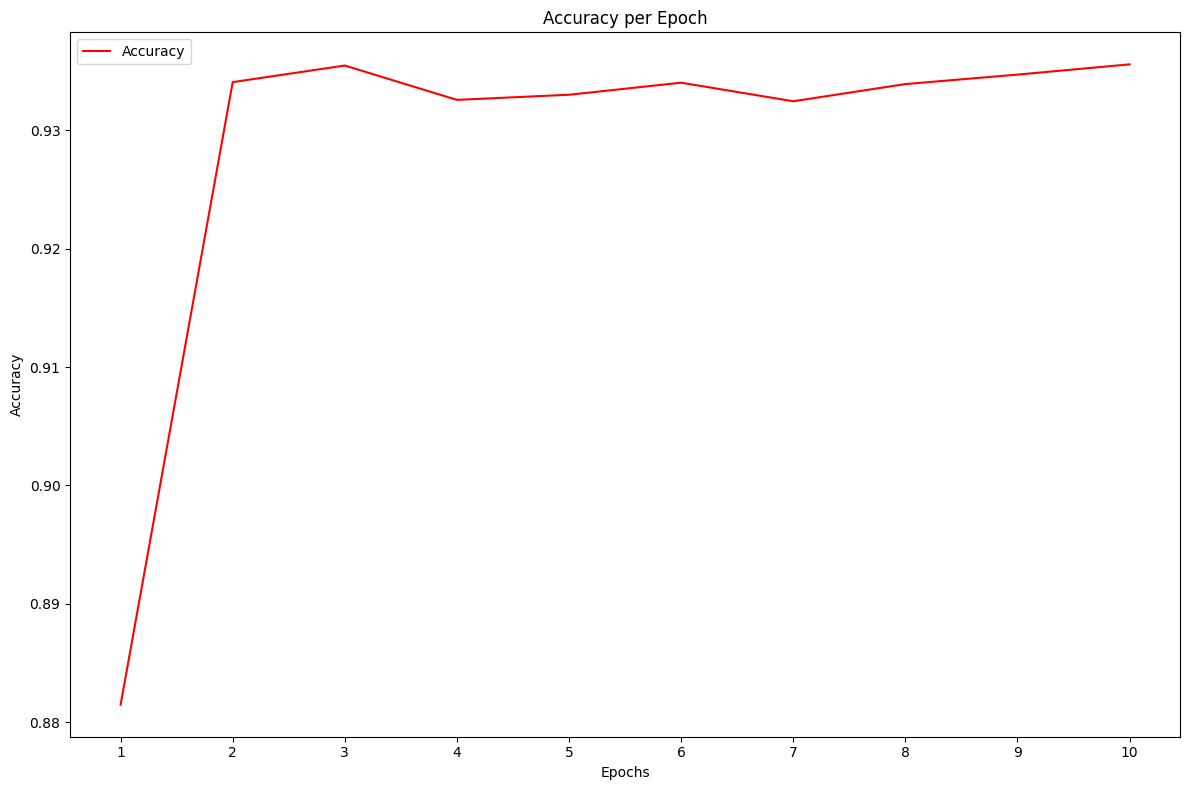

In [7]:
# Prepare folder
output_folder = 'results/RowWiseQuantized_SCCEMaxBin_0_1'
os.makedirs(output_folder, exist_ok=True)

scale_tracking_callback_first_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 1", folder_name=output_folder)
scale_tracking_callback_second_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 2", folder_name=output_folder)
penalty_callback.plot_loss(folder_name=output_folder)
accuracy_callback.plot_accuracy(folder_name=output_folder)

### **8. Before & After quantization**

In [8]:
# Count number of unique values for w and b before and after quantization for each custom layer
count_unique_values(quantized_model, folder_name=output_folder)




--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER

LAYER WITH ID: 0 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 1 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 2
Unique values in w:  100330
Unique values in quantized w:  9
Unique values in b:  128
Unique values in quantized b:  2 

LAYER WITH ID: 3 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 4
Unique values in w:  1280
Unique values in quantized w:  6
Unique values in b:  10
Unique values in quantized b:  6 

LAYER WITH ID: 5 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES


--------------------------------------------------------------------------------

